# In which Elizabeth learns something about forecasting

Playing with Kaggle competition [on predicting future sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales).

## Predicting Sales

Goal: predict total sales for **every product** and **every store** in the test set for the next month. 
Evaluation metric: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [43]:
train = pd.read_csv('sales_train_v2.csv')
train["date"] = pd.to_datetime(train.date)
train = train.sort_values(by='date')
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2915898,2015-12-10,33,6,7390,349.0,1.0
2915896,2015-12-10,33,6,7350,349.0,1.0
2922604,2015-12-10,33,28,10304,199.0,1.0
2915871,2015-12-10,33,6,6798,1849.0,1.0
2898514,2015-12-10,33,58,10207,1199.0,1.0


In [44]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
109593,2013-01-01,0,46,18616,349.0,1.0
85162,2013-01-01,0,54,11854,199.0,1.0
18128,2013-01-01,0,28,4906,1799.0,1.0
112216,2013-01-01,0,42,2931,99.0,1.0
85141,2013-01-01,0,54,11604,349.0,1.0


In [45]:
print(len(train.item_id.unique()), 'unique items were purchased at', len(train.shop_id.unique()), 'unique shops over', \
      len(train.date_block_num.unique()), 'months.')

dfg = train.groupby(['shop_id', 'item_id'])

21807 unique items were purchased at 60 unique shops over 34 months.


In [46]:
def sum_items_sold_each_month(shop_id, item_id):
    try:
        df = dfg.get_group((shop_id, item_id))
    except KeyError:
        return [0]*34
    
    dfs = df.groupby("date_block_num").sum()
    
    if len(dfs.item_cnt_day) < 34:
        y = []
        for x in range(34):
            try: 
                y.append(dfs.loc[x].item_cnt_day)
            except KeyError:
                y.append(0)
        return y
    return dfs.item_cnt_day.values


def plot_items_sold_each_month(shop, item):
    y = sum_items_sold_each_month(shop, item)
    fig = plt.figure()
    plt.plot(range(34), y, 'o-', label='historical data')
    plt.xlabel('month')
    plt.ylabel('total items sold')
    plt.title(' '.join(('Item', str(item), 'sold at Shop', str(shop), 'over time')))
    return fig, plt.gca()


def plot_prediction(shop, item, predicted_val, label='predicted'):
    fig, ax = plot_items_sold_each_month(shop, item)
    ax.plot(34, predicted_val, 'or', label=label)
    ax.set_xlim(0, 35)
    ax.legend()
    

def plot_highlighted_months(shop, item, x=[10, 22], label='previous November data'):
    """ Default months to plot x=[10, 22], the two previous Novembers """
    y = [sum_items_sold_each_month(shop, item)[i] for i in x]
    plt.plot(x, y, 'ok', markerfacecolor='r', label=label)
    plt.legend()
    

def prediction_equals_last_month_average(shop, item):
    """ Submission #1, RMSE = 1.21476 """
    try:
        df = dfg.get_group((shop, item))
    except KeyError:
        return 0
    
    df = df[df.date_block_num == 33]
    ave = df.item_cnt_day.mean()
    if np.isnan(ave):
        return 0
    return ave
    
    
def prediction_equals_last_month_total(shop, item):
    """ Submission #2, RMSE = 8.53027 """
    return sum_items_sold_each_month(shop, item)[-1]


def prediction_equals_nmonth_average(shop, item, n_months):
    """ Submission #3, n_months=5, RMSE = 2.86279 """
    return np.mean(sum_items_sold_each_month(shop, item)[-n_months:])


def prediction_equals_last_November(shop, item):
    """ Submission #4, RMSE = 3.77216 """
    return sum_items_sold_each_month(shop, item)[22]


def prediction_November_average(shop, item):
    """ Submission #5, RMSE = 3.14800 """
    return np.mean([sum_items_sold_each_month(shop, item)[i] for i in [10, 22]])


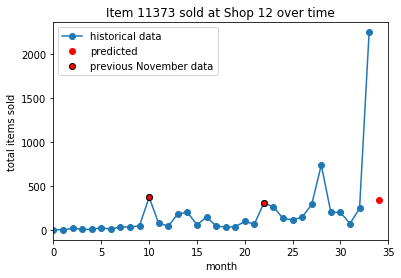

In [47]:
shop = 12
# item = 30
# item = 0
item = 11373 
    
pred = prediction_November_average(shop, item)
plot_prediction(shop, item, pred)
plot_highlighted_months(shop, item)

In [107]:
# looking for examples with lots of sales
train[train.item_cnt_day == np.sort(train.item_cnt_day)[-5]]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2608040,14.04.2015,27,12,3731,1904.548077,624.0


## Preparing the submission
How to make this faster?

In [29]:
test = pd.read_csv('test.csv')
len(test)

214200

In [28]:
def make_predictions(prediction_function, filename='submission.csv', n_months=5):
    shops = test.shop_id.values
    items = test.item_id.values
    IDs = test.ID.values
    output = 'ID,item_cnt_month'

    for shop, item, ID in zip(shops, items, IDs):
        line = ','.join((str(ID), str(prediction_function(shop=shop, item=item))))#, n_months=n_months))))
        output = '\n'.join((output, line))
        
    with open(filename, "w") as f:
        f.write(output)

In [111]:
start = timer()
make_predictions(prediction_function=prediction_November_average, 
                 filename='submission05_November_average.csv')
end = timer()

print('Finished in {:.1f} minutes'.format((end-start)/60))

Finished in 26.3 minutes
